**Genetic Linkage Map Data Extraction**

Our Goal is to parse an image with Genetic Linkage Map (see image) and extract the name of the markers (on the right side of the image) and the information on linear scale (on the left side of image) and approximate the position of each marker on the linear scale.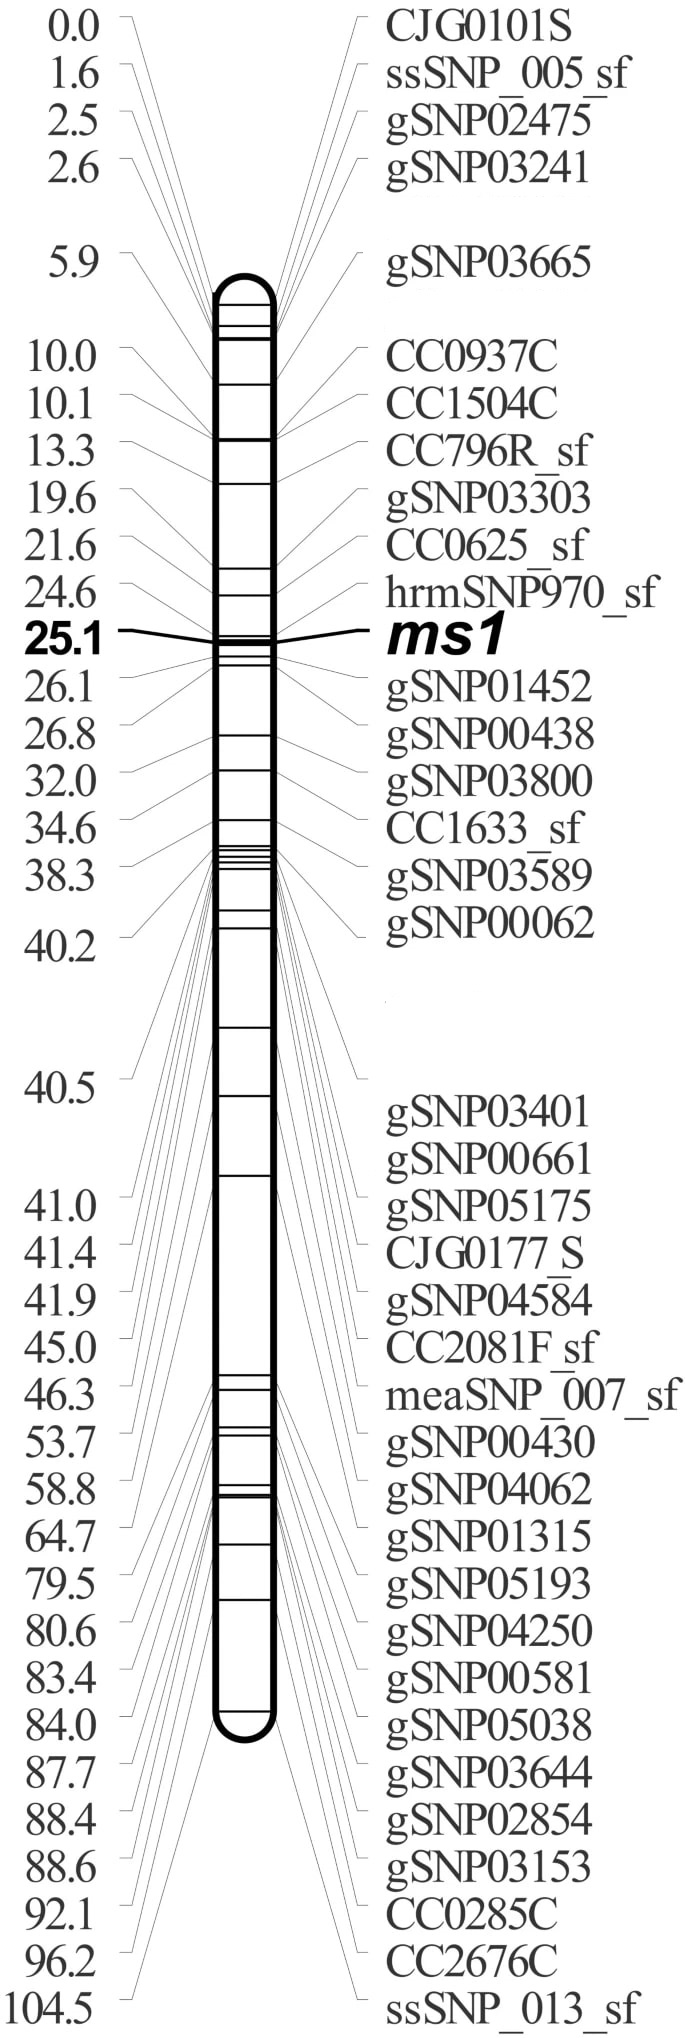

**Algorithm**:



1.   Process the image (Grayscale--> Blurr-->Binarization-->Dialtion)
2.   Identify the most leftmost vertical line (using Probabilistic Hough Line Detection and divide the image into two segments on either side of the line: Left One containing Scale and the other containing Markers Names.
3. Use OCR to gather Digits on scale from the scale image
4. Use OCR to gather Marker Names on scale from the marker image
5. Detect the number of intersections on the Vertical line using Probabilistic Hough Line Detection to detect lines and line formula (y=mx+c) to find out the point of intersection
6. Decompose the number of markings to the number to the number of Markers (let there be n marker; divide the scale into n equal portions; if there less markers use average interpolation; now sort the markings and marker names (by coordinates) and assign mth marking to mth Marker.



We will be using pytesseract as our OCR

In [3]:
%pip install pytesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


We start by  Defining some small functions that will aid our task.

Functions:

**Segmentation**: We assume the image to consist of two halves (the scale and the marker name). SO we split the image into two to process each seperately.
We do this by finding region that have unusual pixel values.
For example say a horizontal row is like [white, white, white, black, black, white white].
Here we find our two regions as [white, white, white] and [white, white]
while [black, black]  is the odd region. We return all the segments that have odd regions i.e where average count of black pixel were more (2 times) compared to overall average count in the image.


**break_region**: This functions gives the horizontal coordinates for the regions computed above. It chooses the greatest horizontal coordinate out of all the regions.



**remove_control_characters**: This functions removes control characters from the Marker Names predicted by the OCR.


**reject_outliers**: This removes outliers values detected on the scale.

**average**: Computes mean value of an Array

In [4]:
import unicodedata
import re

def segmentation(arr,odd_val):
    en_ar=[]
    for i in arr:
        if i==odd_val:
            en_ar.append(1)
        else:
            en_ar.append(0)
    b=sum(en_ar)/len(en_ar)
    k=0
    l=0
    p=0
    i=0
    reg=[]
    while i < (len(en_ar)):
        if en_ar[i]==1:
            k=0
            l=0
            for j in range(i, len(en_ar)):
                k+=en_ar[j]
                l+=1
                if (en_ar[j]==0 and k/l>b) or j==len(en_ar)-1:
                    tmp=j-1 if j!=len(en_ar)-1 else j
                    reg.append([i-int(2*b),tmp+int(2*b)])
                    i=j
                    break

        i+=1
    return reg

def break_region(arr):
    lp=[]
    for i in range(len(arr)-1):
        lp.append(arr[i+1][1]-arr[i][0])
    return lp.index(max(lp))


def remove_control_characters(s):
    return "".join(ch for ch in s if unicodedata.category(ch) and unicodedata.category(ch)[0] != "C")

def reject_outliers(_data, m = 2.8):
    data=np.array(_data, dtype=np.float32)
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]


def average(ar):
  return sum(ar)/len(ar)


**scale_decomposition**: The positions detected on the scale may not equal the number of markers detected as many lines close to actual marking are also picked up by the ocr. To solve this problem we reduce a group of markings to their average value and decompose N markings to the number of Markers detected.

**map_real_world_scale**: This converts the distance between the marker coordinated into distance inferred from the scale.

**vertical_scale_cordinate**: Uses Probabilistic Hough Line Detection to detect Vertical Lines on the image. Assigns the most prominent vertical line (using very high threshold value) in the scale segment of the image as the scale.

**horizantal_scale_cordinate**: Uses Probabilistic Hough Line Detection to detect lines that intersect with the above found vertical line and returns their coordinates.


Calculations for vertical and horizontal lines are as follows:
y=mx+c ---Line Formula
Here y= column
m= slope (tan of angle made by line and the horizontal axis)
c is the y-intercept

For a point of in vertical lines their horizontal coordinates are equal (x1=x2)

After finding the line we find vertical coordinate of our intersection by Line Formula

In [5]:

def scale_decomposition(a,n_group):
    n=len(a)
    av=int(sum(a)/n)
    rem_gs=[av]*(n_group*(int(n/n_group)+1)-n)
    f_l=a+rem_gs
    f_l.sort()
    nw_s=len(f_l)/n_group
    tmp=[]
    g_l=[]
    for i in range(len(f_l)):
        tmp.append(f_l[i])
        if (i+1)%nw_s==0:
            g_l.append(tmp)
            tmp=[]
    g_l_f=[]
    for i in g_l:
      g_l_f.append(average(i))
    return(g_l_f)

def map_real_world_scale(a,v):
    b=[]
    c=[]
    for i in a:
        b.append(i-a[0])
    f=b[-1]/v
    for i in b:
        c.append(round((float(i/f)),2))
    return c




import cv2
import numpy as np

def vertical_scale_cordinate(img):

  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  blurred_img = cv2.GaussianBlur(gray, (5, 5), 0)
  edges = cv2.Canny(blurred_img,50,500,apertureSize = 3)
  minLineLength = 100
  maxLineGap = 0.4
  lines = cv2.HoughLinesP(edges,1,np.pi/90,200,minLineLength,maxLineGap)
  ver=[]
  for line in lines:
      x1,y1,x2,y2=line[0]
      if x1-x2==0:
        ver.append(x1)
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),1)
  return(max(ver))


def horizantal_scale_cordinate(img,ver):

  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  blurred_img = cv2.GaussianBlur(gray, (5, 5), 0)
  edges = cv2.Canny(blurred_img,50,500,apertureSize = 3)
  minLineLength = 100
  maxLineGap = 0
  lines = cv2.HoughLinesP(edges,1,np.pi/90,40,minLineLength,maxLineGap)
  hr=[]
  for line in lines:
      x1,y1,x2,y2=line[0]
      cv2.line(img,(x1,y1),(x2,y2),(0,255,0),1)
      if x1==x2:
        continue
      sl=float(y2-y1)/float(x1-x2)
      c=-float(y1)-float(sl*x1)
      hor=sl*ver+c
      hr.append(float(-hor))

  return hr

**find_and_mark_regions**: This function does basic image pre-proceesing. They are as follows:


*   Grayscaling the image
*   Blurring the image to smoothen it
*   Applying Adaptive Threshold on the image
*   Dilating the image

It then picks random horizontal lines on the image (here at distance height/2
height/3,height/4,height/6,height/7 positions) and send them for checking odd regions and breaking the image into two components basis that: Marker Region and Scale Region






In [20]:
import cv2
import numpy as np

def find_and_mark_regions(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
  binary_img = cv2.adaptiveThreshold(
    blurred_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
)

# Dilation/erosion
  kernel = np.ones((1, 1), np.uint8)
  binary_img = cv2.dilate(binary_img, kernel, iterations=1)



  sample_rows=[2,3,4,6,7]
  scale=[]
  markers=[]
  for i in sample_rows:
    mid_y=int(binary_img.shape[0]/i)
    region=segmentation(binary_img[mid_y],0)
    brk=break_region(region)
    scale.append(region[brk][1])
    markers.append(region[brk+1][0])

  row=binary_img.shape[0]
  col=binary_img.shape[1]
  m2=max(scale)+int(max(scale)/8)
  m3=min(markers) -int(max(markers)/10)


  cv2.imwrite("/content/scale_image.jpg", binary_img[:,0:m2])
  cv2.imwrite("/content/marker_image.jpg", binary_img[:,m3:col])
  cv2.imwrite("/content/horizontal_markup.jpg", binary_img[:,m3:m2])
  return(binary_img[:,0:m2],binary_img[:,m3:col])



image_file = "/content/lm 9.jpg"  # Replace with the actual image path.

bi_s,bi_m=find_and_mark_regions(image_file)



Here we use pytesseract OCR to scan the image.
In the scale region we use PSM 11* config and find the coordinate of each number (and discrad non-numeral data using regex).
We use default config on the marker image to find the marker names.
We then process the data to remove control charcaters, extra spaces etc.
We then map the marker names with values on scale (using the average method discussed above).


* Page segmentation modes 11 is for finding:
Sparse text. Find as much text as possible in no particular order.




In [21]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

from PIL import Image

extracted_text = pytesseract.image_to_string(bi_m)
data = pytesseract.image_to_data(bi_s, output_type=pytesseract.Output.DICT, config='--psm 11')
text_data = []
for i in range(len(data['text'])):
    if re.sub('[^0-9.]','', data['text'][i]) and re.sub('[^0-9.]','', data['text'][i])!='.': # Check for non-empty text
        text_data.append({
            'text': re.sub('[^0-9.]','', data['text'][i]),
            'top': data['top'][i]  # Y-coordinate of the bounding box
        })

sorted_text = sorted(text_data, key=lambda x: x['top'])
final_text = '\n'.join([item['text'] for item in sorted_text])
final_numbers=[]
for j in final_text.split("\n"):
  final_numbers.append(float(j))

final_numbers.sort()


cleaned_extract = [remove_control_characters(item) for item in extracted_text.split("\n")]
cleaned_extract_f=[]
for i in cleaned_extract:
  if i.replace(' ',''):
    cleaned_extract_f.append(i)





img=cv2.imread("/content/horizontal_markup.jpg")
scale_col=float(vertical_scale_cordinate(img))
scale_hor=(horizantal_scale_cordinate(img,scale_col))
scale_hor_f=scale_decomposition(scale_hor,len(cleaned_extract_f))
final_numbers=reject_outliers(final_numbers)
scale_map=map_real_world_scale(scale_hor_f,float(final_numbers[-1])) #final_numbers[-1]
final_dict=dict(zip(cleaned_extract_f,scale_map))
img_o2 = cv2.imread(image_file, cv2.IMREAD_COLOR)

for i in final_dict.keys():
  print(i,final_dict[i])


Bulge 0.0
Crocs 40.63
Paste, Crop 50.81
Stub 65.52
Plus 75.0


**Outputs:**

I have used a simple image for illustration purposes.

 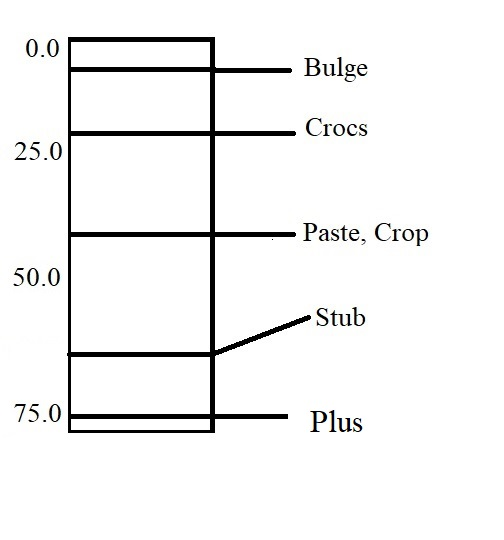